In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import cv2
import numpy as np
from collections import defaultdict

import scikitplot
import seaborn as sns
from matplotlib import pyplot

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import TimeDistributed, LSTM, Bidirectional
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import zipfile
import os
import shutil

In [3]:
# Downloading dataset. Change according to folder you store it
INPUT_PATH = "/Users/ksatyabharathi/Downloads/tmp/CK+48/"
# with zipfile.ZipFile("CK+48.zip", 'r') as zip_ref:
#     zip_ref.extractall('tmp')
for dir_ in os.listdir(INPUT_PATH):
    if(dir_[0]=='.'):
      continue
    count = 0
    for f in os.listdir(INPUT_PATH + dir_ + "/"):
        count += 1
    print(f"{dir_} has {count} number of images")

happy has 207 number of images
contempt has 54 number of images
fear has 75 number of images
surprise has 249 number of images
sadness has 84 number of images
anger has 135 number of images
disgust has 177 number of images


In [4]:
# These emotions were chosen as only these had sample size enough to classify

TOP_EMOTIONS = ["happy", "surprise", "anger", "sadness", "fear"]

In [5]:
INPUT_PATH = "tmp/CK+48/"
# Here we split the dataset depending on the folders which are the emotions

data = defaultdict(str)
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        data[dir_] = defaultdict(list)
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            sub = f.split("_")[0]
            data[dir_][sub].append(f)

In [6]:
# The CK+ dataset has files names such that it helps us
# undestand the test subject and emotion. In this block
# we are grouping images belonging to the same person and
# emotion and converting them into arrays
def preprocess_list(x):
    return int((x.split("_")[2]).split(".")[0])

def preprocess_dict(x):
    res = list(np.argsort(list(map(preprocess_list, x))))
    return [x[i] for i in res]

def img2array(x,path):
    arr = np.empty(shape=(3,48,48))
    for i,f in enumerate(x):
        img = cv2.imread(path+f, 0)
        arr[i] = img
    return arr

In [7]:
# Where the above functions are called
for emotion in data:
    data[emotion] = dict((k, preprocess_dict(v)) for k, v in data[emotion].items())
    data[emotion] = dict((k, img2array(v, path=INPUT_PATH + emotion + "/")) for k, v in data[emotion].items())

# data

In [8]:
# Printing grouped samples
for k,v in data.items():
    print(f"{k} has {len(v)} samples")

happy has 69 samples
fear has 25 samples
surprise has 83 samples
sadness has 28 samples
anger has 45 samples


In [10]:
from tensorflow.keras.utils import to_categorical


In [12]:
# Split data, reshape it and create output matrux
surprise = np.stack(data["surprise"].values(), axis=0)
surprise = surprise.reshape(*surprise.shape,1)

happy = np.stack(data["happy"].values(), axis=0)
happy = happy.reshape(*happy.shape,1)

anger = np.stack(data["anger"].values(), axis=0)
anger = anger.reshape(*anger.shape,1)

sadness = np.stack(data["sadness"].values(), axis=0)
sadness = sadness.reshape(*sadness.shape,1)

fear = np.stack(data["fear"].values(), axis=0)
fear = fear.reshape(*fear.shape,1)

X = np.concatenate((surprise, happy, anger, sadness, fear))
y = np.concatenate((np.array([0]*83), np.array([1]*69), np.array([2]*45), np.array([3]*28), np.array([4]*25)))
y = to_categorical(y)

X.shape, y.shape

((250, 3, 48, 48, 1), (250, 5))

In [13]:
label_emotion_mapper = {0:"surprise", 1:"happy", 2:"anger", 3:"sadness", 4:"fear"}

In [14]:
# Split into train and test data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, stratify=y, shuffle=True, random_state=42)
X_train.shape, X_valid.shape

((175, 3, 48, 48, 1), (75, 3, 48, 48, 1))

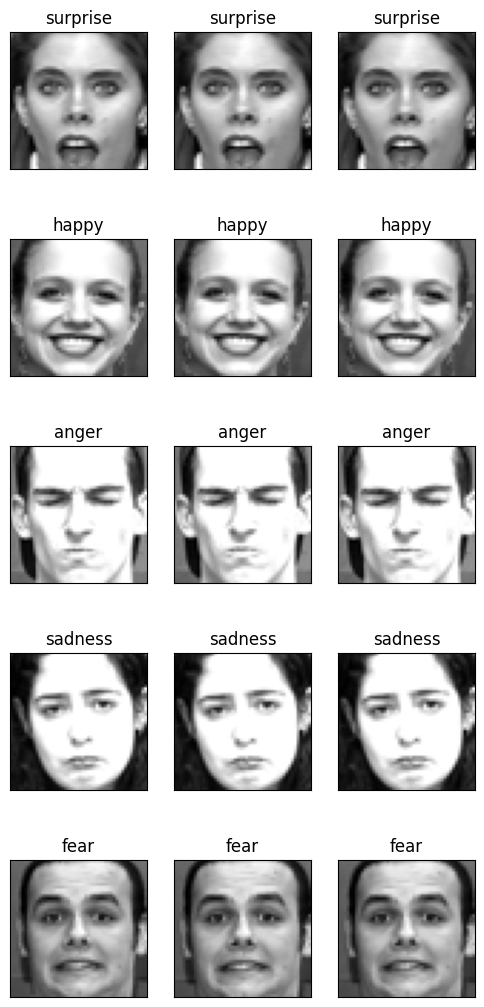

In [15]:
np.random.seed(42)
surprise_idx = np.random.choice(np.where(y_train[:, 0]==1)[0], size=1)
happy_idx = np.random.choice(np.where(y_train[:, 1]==1)[0], size=1)
anger_idx = np.random.choice(np.where(y_train[:, 2]==1)[0], size=1)
sad_idx = np.random.choice(np.where(y_train[:, 3]==1)[0], size=1)
fear_idx = np.random.choice(np.where(y_train[:, 4]==1)[0], size=1)

fig = pyplot.figure(1, (6,13))

i = 0
for name, idx in zip(label_emotion_mapper.values(), [surprise_idx, happy_idx, anger_idx, sad_idx, fear_idx]):
    for j in range(3):
        i += 1
        ax = pyplot.subplot(5,3,i)
        sample_img = X_train[idx][0,j,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(name)

In [16]:
# data normalization
X_train = X_train / 255.
X_valid = X_valid / 255.

In [17]:
def build_dcnn(input_shape, show_arch=True):
    # The model uses ELU function and so we use he_normal as initializer. Refer to report for more details on architecure.
     net = Sequential(name='DCNN')

    # Layer 1
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(3,3),
            input_shape=input_shape,
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.45, name='dropout_1'))

    # Layer 2
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.45, name='dropout_2'))

    #Layer 3
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.4, name='dropout_3'))

    # Layer 4
    net.add(
        Conv2D(
            filters=512,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_7'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    net.add(
        Conv2D(
            filters=512,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_8'
        )
    )
    net.add(BatchNormalization(name='batchnorm_8'))
    
    net.add(Dropout(0.4, name='dropout_4'))
    
    # Pool all to one
    net.add(GlobalMaxPool2D(name="globalmax2d"))
    
    if show_arch:
        net.summary()
    
    return net

In [18]:
def memory_model(input_shape, num_class, show_arch=True):
    dcnn = build_dcnn(input_shape[1:], show_arch=False)
    
    model = Sequential(name="convolutional_Bidrectional_LSTM")

    # We use time distributed to pass the values of three frames to CNN and then pass those time distruuted values to LSTM
    model.add(
        TimeDistributed(
            dcnn,
            input_shape=input_shape,
            name="time_distributed",
        )
    )
    
    # 2 layers of bi-directional LSTM 
    model.add(Bidirectional(LSTM(128, return_sequences=True, name="bidirect_lstm_1")))
    model.add(Dropout(.35, name="dropout_1"))
    model.add(Bidirectional(LSTM(64, return_sequences=False, name="bidirect_lstm_2")))
    model.add(Dropout(.45, name="dropout_2"))

    # Final dense layer with ELU, Batch Normalization and Dropout
    model.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    model.add(BatchNormalization(name='batchnorm_1'))
    model.add(Dropout(.7, name="dropout_3"))

    # Softmax function to predict
    model.add(
        Dense(
            num_class,
            activation='softmax',
            name='out_layer'
        )
    )
    
    if show_arch:
        model.summary()
    
    return model

In [19]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00005,
    patience=12,
    verbose=1,
    restore_best_weights=True,
)

# We choose the ReduceLROnPlateau as it helped converge better

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.8,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
#     early_stopping,
    lr_scheduler,
]

batch_size = 32
epochs = 200

In [21]:
INPUT_SHAPE = (3, 48, 48, 1)
# Nadam optimizer used 
optim = tf.keras.optimizers.legacy.Nadam(0.001)

model = memory_model(INPUT_SHAPE, num_class=5)
# compile the model
model.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
)

Model: "convolutional_Bidrectional_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 3, 512)            4691904   
 ributed)                                                        
                                                                 
 bidirectional_2 (Bidirecti  (None, 3, 256)            656384    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 3, 256)            0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                   

In [22]:
# training the model
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_valid, y_valid),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Epoch 1/200
6/6 [==============================] - 10s 1s/step - loss: 3.4084 - accuracy: 0.1771 - val_loss: 1.5726 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/200
6/6 [==============================] - 7s 1s/step - loss: 3.2278 - accuracy: 0.1943 - val_loss: 1.5934 - val_accuracy: 0.2800 - lr: 0.0010
Epoch 3/200
6/6 [==============================] - 7s 1s/step - loss: 2.9591 - accuracy: 0.2000 - val_loss: 1.5524 - val_accuracy: 0.2800 - lr: 0.0010
Epoch 4/200
6/6 [==============================] - 7s 1s/step - loss: 3.1105 - accuracy: 0.1943 - val_loss: 1.5634 - val_accuracy: 0.3067 - lr: 0.0010
Epoch 5/200
6/6 [==============================] - 6s 1s/step - loss: 2.8377 - accuracy: 0.2171 - val_loss: 1.5516 - val_accuracy: 0.2800 - lr: 0.0010
Epoch 6/200
6/6 [==============================] - 6s 1s/step - loss: 2.7184 - accuracy: 0.2457 - val_loss: 1.5729 - val_accuracy: 0.2933 - lr: 0.0010
Epoch 7/200
6/6 [==============================] - 7s 1s/step - loss: 2.7023 - accuracy: 0.26

Epoch 49/200
6/6 [==============================] - 7s 1s/step - loss: 0.7837 - accuracy: 0.6971 - val_loss: 0.6346 - val_accuracy: 0.7467 - lr: 3.2768e-04
Epoch 50/200
6/6 [==============================] - 7s 1s/step - loss: 0.8858 - accuracy: 0.7257 - val_loss: 0.6215 - val_accuracy: 0.7333 - lr: 3.2768e-04
Epoch 51/200
6/6 [==============================] - 7s 1s/step - loss: 0.8222 - accuracy: 0.7371 - val_loss: 0.5868 - val_accuracy: 0.7867 - lr: 3.2768e-04
Epoch 52/200
6/6 [==============================] - 7s 1s/step - loss: 0.7534 - accuracy: 0.7714 - val_loss: 0.5005 - val_accuracy: 0.7867 - lr: 3.2768e-04
Epoch 53/200
6/6 [==============================] - 7s 1s/step - loss: 0.8181 - accuracy: 0.7086 - val_loss: 0.5446 - val_accuracy: 0.7733 - lr: 3.2768e-04
Epoch 54/200
6/6 [==============================] - 7s 1s/step - loss: 0.6529 - accuracy: 0.7714 - val_loss: 0.5351 - val_accuracy: 0.7867 - lr: 3.2768e-04
Epoch 55/200
6/6 [==============================] - 7s 1s/step -

6/6 [==============================] - 7s 1s/step - loss: 0.4560 - accuracy: 0.8057 - val_loss: 0.3285 - val_accuracy: 0.8933 - lr: 1.3422e-04
Epoch 98/200
6/6 [==============================] - ETA: 0s - loss: 0.3827 - accuracy: 0.8229
Epoch 98: ReduceLROnPlateau reducing learning rate to 0.00010737419361248613.
6/6 [==============================] - 7s 1s/step - loss: 0.3827 - accuracy: 0.8229 - val_loss: 0.3160 - val_accuracy: 0.8533 - lr: 1.3422e-04
Epoch 99/200
6/6 [==============================] - 7s 1s/step - loss: 0.4163 - accuracy: 0.8286 - val_loss: 0.2980 - val_accuracy: 0.8400 - lr: 1.0737e-04
Epoch 100/200
6/6 [==============================] - 7s 1s/step - loss: 0.3856 - accuracy: 0.8686 - val_loss: 0.2857 - val_accuracy: 0.8667 - lr: 1.0737e-04
Epoch 101/200
6/6 [==============================] - 7s 1s/step - loss: 0.4374 - accuracy: 0.8114 - val_loss: 0.2863 - val_accuracy: 0.8933 - lr: 1.0737e-04
Epoch 102/200
6/6 [==============================] - 7s 1s/step - loss: 

6/6 [==============================] - 7s 1s/step - loss: 0.2663 - accuracy: 0.8971 - val_loss: 0.2387 - val_accuracy: 0.8933 - lr: 2.8147e-05
Epoch 143/200
6/6 [==============================] - 7s 1s/step - loss: 0.2858 - accuracy: 0.9029 - val_loss: 0.2394 - val_accuracy: 0.9067 - lr: 2.8147e-05
Epoch 144/200
6/6 [==============================] - 7s 1s/step - loss: 0.3892 - accuracy: 0.8629 - val_loss: 0.2380 - val_accuracy: 0.9067 - lr: 2.8147e-05
Epoch 145/200
6/6 [==============================] - 7s 1s/step - loss: 0.3322 - accuracy: 0.8857 - val_loss: 0.2389 - val_accuracy: 0.9067 - lr: 2.8147e-05
Epoch 146/200
6/6 [==============================] - 6s 1s/step - loss: 0.3581 - accuracy: 0.8629 - val_loss: 0.2404 - val_accuracy: 0.9067 - lr: 2.8147e-05
Epoch 147/200
6/6 [==============================] - 6s 1s/step - loss: 0.3529 - accuracy: 0.8514 - val_loss: 0.2489 - val_accuracy: 0.9067 - lr: 2.8147e-05
Epoch 148/200
6/6 [==============================] - ETA: 0s - loss: 0.2

6/6 [==============================] - 7s 1s/step - loss: 0.3233 - accuracy: 0.8857 - val_loss: 0.2389 - val_accuracy: 0.9200 - lr: 7.3787e-06
Epoch 189/200
6/6 [==============================] - 7s 1s/step - loss: 0.3620 - accuracy: 0.8629 - val_loss: 0.2345 - val_accuracy: 0.9067 - lr: 7.3787e-06
Epoch 190/200
6/6 [==============================] - 6s 1s/step - loss: 0.3015 - accuracy: 0.8857 - val_loss: 0.2330 - val_accuracy: 0.9067 - lr: 7.3787e-06
Epoch 191/200
6/6 [==============================] - 7s 1s/step - loss: 0.3268 - accuracy: 0.8686 - val_loss: 0.2337 - val_accuracy: 0.9067 - lr: 7.3787e-06
Epoch 192/200
6/6 [==============================] - ETA: 0s - loss: 0.2914 - accuracy: 0.9029
Epoch 192: ReduceLROnPlateau reducing learning rate to 5.902958946535364e-06.
6/6 [==============================] - 7s 1s/step - loss: 0.2914 - accuracy: 0.9029 - val_loss: 0.2361 - val_accuracy: 0.9067 - lr: 7.3787e-06
Epoch 193/200
6/6 [==============================] - 7s 1s/step - loss

In [25]:
model.save_weights('my_model')

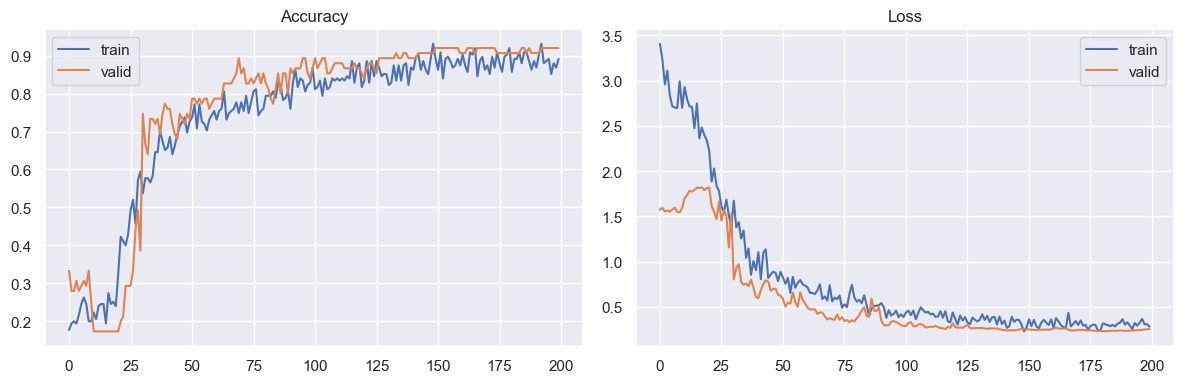

In [23]:
# Plotting the model metrics
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history.png')
pyplot.show()

Model: "convolutional_Bidrectional_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 3, 512)            4691904   
 ributed)                                                        
                                                                 
 bidirectional_4 (Bidirecti  (None, 3, 256)            656384    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 3, 256)            0         
                                                                 
 bidirectional_5 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                   

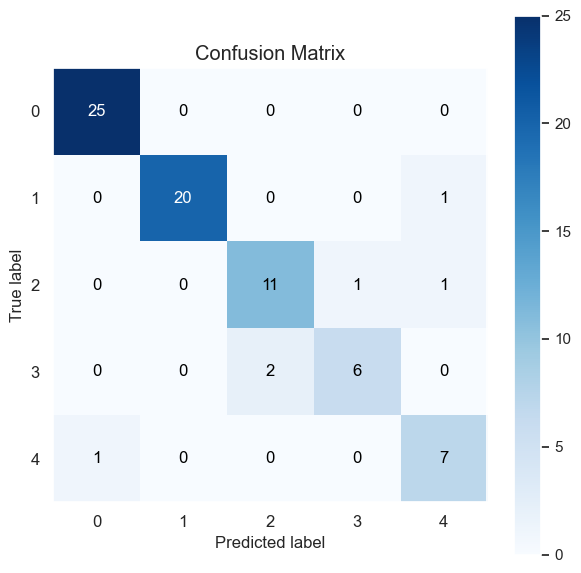

In [26]:
# Plotting confusion matrix
# yhat_valid = model.predict_classes(X_valid)
# Create a new model instance
model = memory_model(INPUT_SHAPE, num_class=5)

# Restore the weights
model.load_weights('my_model')
predict_x=model.predict(X_valid) 
yhat_valid=np.argmax(predict_x,axis=1)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

(3, 48, 48, 1)
1/1 [==============================] - 0s 25ms/step
(3, 48, 48, 1)
1/1 [==============================] - 0s 21ms/step
(3, 48, 48, 1)
1/1 [==============================] - 0s 22ms/step
(3, 48, 48, 1)
1/1 [==============================] - 0s 21ms/step
(3, 48, 48, 1)
1/1 [==============================] - 0s 20ms/step
(3, 48, 48, 1)
1/1 [==============================] - 0s 21ms/step
(3, 48, 48, 1)
1/1 [==============================] - 0s 21ms/step
(3, 48, 48, 1)
1/1 [==============================] - 0s 20ms/step
(3, 48, 48, 1)
1/1 [==============================] - 0s 21ms/step
(3, 48, 48, 1)
1/1 [==============================] - 0s 21ms/step
(3, 48, 48, 1)
1/1 [==============================] - 0s 23ms/step
(3, 48, 48, 1)
1/1 [==============================] - 0s 25ms/step
(3, 48, 48, 1)
1/1 [==============================] - 0s 24ms/step
(3, 48, 48, 1)
1/1 [==============================] - 0s 23ms/step
(3, 48, 48, 1)
1/1 [==============================] - 0s 22ms/

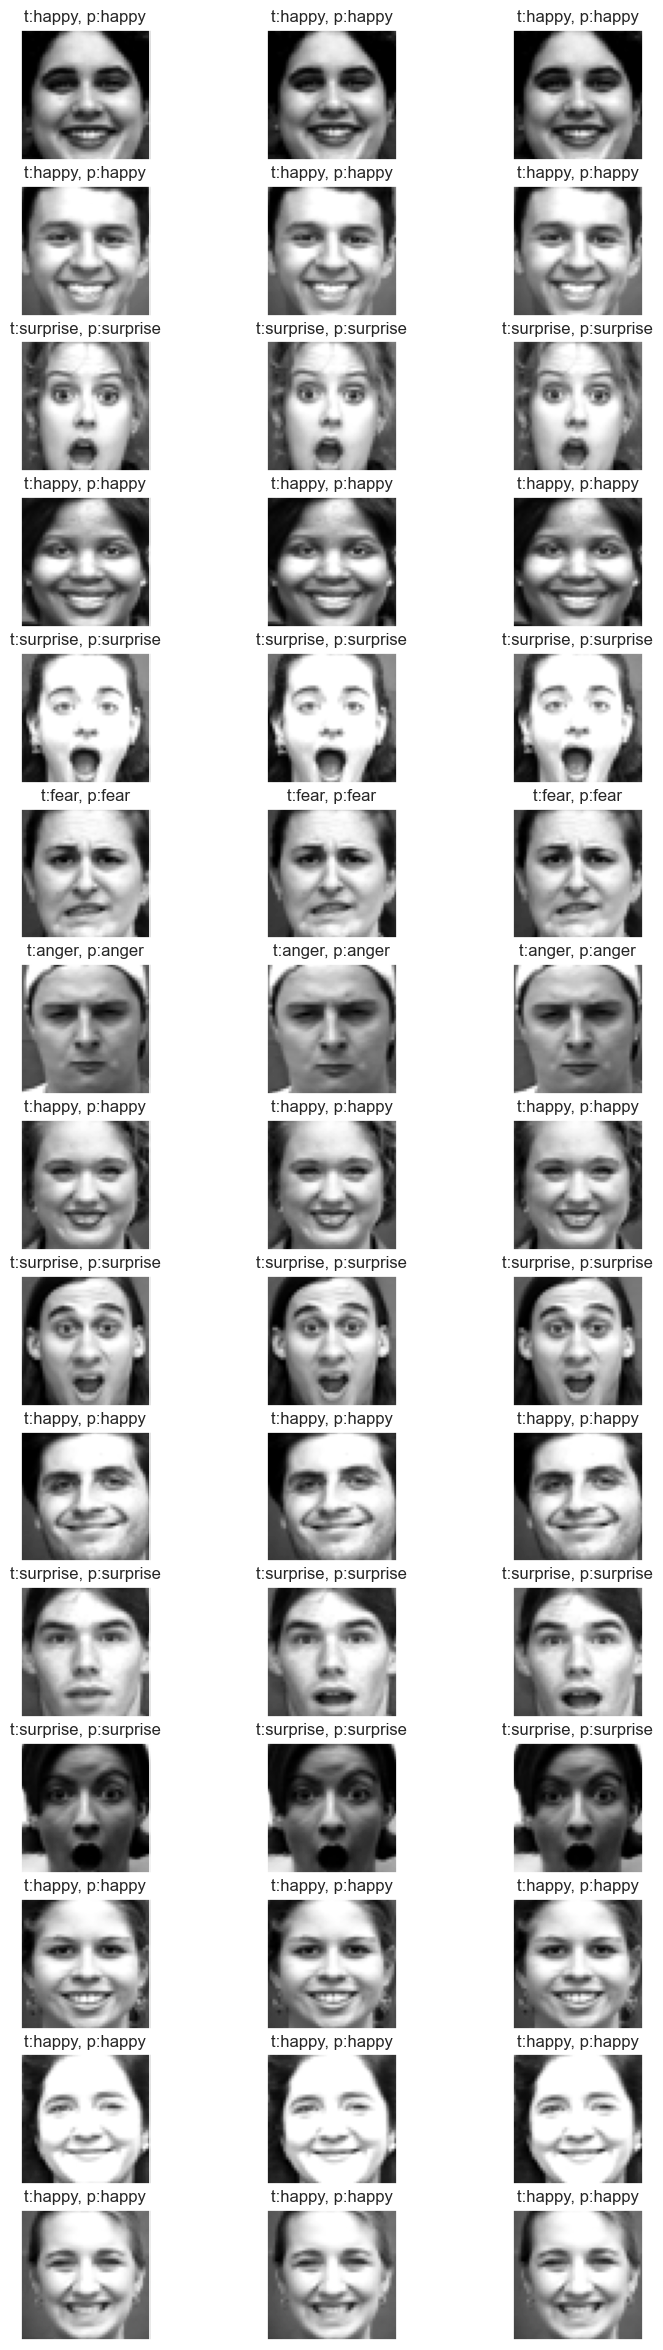

In [27]:
np.random.seed(0)
indices = np.random.choice(range(X_valid.shape[0]), size=15, replace=False)

fig = pyplot.figure(1, (9,30))

i = 0
for idx in indices:
    true_emotion = label_emotion_mapper[np.argmax(y_valid[idx])]
    print(X_valid[idx].shape)
    predict_x=model.predict(np.expand_dims(X_valid[idx], axis=0)) 
    yhat_valid=np.argmax(predict_x,axis=1)
    pred_emotion = label_emotion_mapper[yhat_valid[0]]
    
    for j in range(3):
        i += 1
        ax = pyplot.subplot(15,3,i)
        sample_img = X_valid[idx,j,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:{true_emotion}, p:{pred_emotion}")

In [28]:
model.save("my_model")

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets
